In [1]:
import pandas as pd

# Load the PLD_Production and Tapes_4mm files (ensure the correct file paths in your environment)
tapes_4mm = pd.read_excel('/Users/Mete/Downloads/Tapes_4mm.xlsx')
pld_production = pd.read_excel('/Users/Mete/Downloads/PLD_Production.xlsx')

# (joining tables via Foregin Id)
merged_data = pd.merge(tapes_4mm, pld_production[['ID', 'Ic_77K']], how='inner', left_on='ID_12mm', right_on='ID')

#$: This symbol specifies that the pattern must be at the end of the string. So, the code is looking for ‘N1’, ‘N2’, or ‘N3’ at the end of the tape name.
merged_data['Tape_Portion'] = merged_data['Tape Name'].str.extract(r'(N1|N2|N3)$')

# Step 3: Split the data into separate datasets for N1, N2, and N3
n1_data = merged_data[merged_data['Tape_Portion'] == 'N1'].copy()  
n2_data = merged_data[merged_data['Tape_Portion'] == 'N2'].copy()
n3_data = merged_data[merged_data['Tape_Portion'] == 'N3'].copy()

# Step 4: Create three datasets for current density calculation
width_4mm = 4e-3  # in meters
thickness_4mm = 58e-6  # in meters
area_4mm = width_4mm * thickness_4mm  # in square meters

# For N1
n1_data.loc[:, 'J_4mm_N1'] = n1_data['Ic_77K_x'] / area_4mm * 1e-6  # Convert A/m² to A/mm²
n1_dataset = n1_data[['Ic_77K_y', 'J_4mm_N1']].dropna()  # Drop NaNs and keep relevant columns
n1_dataset.columns = ['Ic_12mm', 'J_4mm_N1']

# For N2
n2_data.loc[:, 'J_4mm_N2'] = n2_data['Ic_77K_x'] / area_4mm * 1e-6
n2_dataset = n2_data[['Ic_77K_y', 'J_4mm_N2']].dropna()
n2_dataset.columns = ['Ic_12mm', 'J_4mm_N2']

# For N3
n3_data.loc[:, 'J_4mm_N3'] = n3_data['Ic_77K_x'] / area_4mm * 1e-6
n3_dataset = n3_data[['Ic_77K_y', 'J_4mm_N3']].dropna()
n3_dataset.columns = ['Ic_12mm', 'J_4mm_N3']

# Now n1_dataset, n2_dataset, and n3_dataset are ready


/var/folders/xz/5v9t2v4n0_x9g5q2tltg8ggm0000gp/T/ipykernel_19714/1661170901.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [16]:
zero_count1 = (n1_dataset == 0).sum().sum()
print(zero_count1)
zero_count2 = (n2_dataset == 0).sum().sum()
print(zero_count2)
zero_count3 = (n3_dataset == 0).sum().sum()
print(zero_count3)
#19 zeroes in n1_dataset, 9 zeroes in n2_dataset, 14 zeroes in n3 dataset. They can be cleaned by using:
#df = df[(df != 0).all(axis=1)]

19
9
14


/var/folders/xz/5v9t2v4n0_x9g5q2tltg8ggm0000gp/T/ipykernel_19714/3606550713.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  envelope_data_n1_clean = n1_dataset.groupby('bins').agg(


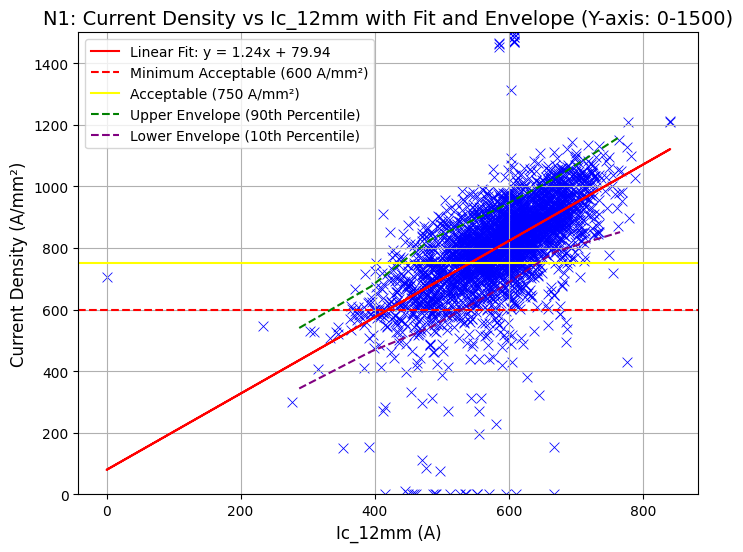

In [9]:
#In this cell, you can change all "n1" with "n2" or "n3" to see the same graph for different portions of the tape

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

X_n1_clean = n1_dataset['Ic_12mm'].values.reshape(-1, 1)  # This line extracts the 'Ic_12mm' column from n1_dataset, converts it into a NumPy array, reshapes it into a 2D array with one column, and assigns it to X_n1_clean. 
y_n1_clean = n1_dataset['J_4mm_N1'].values  # Current density for N1

model_n1_clean = LinearRegression() 
model_n1_clean.fit(X_n1_clean, y_n1_clean)

slope_n1_clean = model_n1_clean.coef_[0]
intercept_n1_clean = model_n1_clean.intercept_

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Ic_12mm', y='J_4mm_N1', data=n1_dataset, s=50, color='blue', marker='x')

plt.plot(n1_dataset['Ic_12mm'], model_n1_clean.predict(X_n1_clean), color='red', label=f'Linear Fit: y = {slope_n1_clean:.2f}x + {intercept_n1_clean:.2f}')

plt.axhline(y=600, color='red', linestyle='--', label='Minimum Acceptable (600 A/mm²)')
plt.axhline(y=750, color='yellow', linestyle='-', label='Acceptable (750 A/mm²)')

num_bins = 8  # Reduce the number of bins for better distribution of data
n1_dataset['bins'] = pd.cut(n1_dataset['Ic_12mm'], bins=num_bins)

def safe_percentile(x, q):
    if len(x) > 1:
        return np.percentile(x, q)
    else:
        return np.nan  

envelope_data_n1_clean = n1_dataset.groupby('bins').agg(
    Ic_12mm_bin_center=('Ic_12mm', 'mean'),
    J_4mm_N1_max=('J_4mm_N1', lambda x: safe_percentile(x, 90)),
    J_4mm_N1_min=('J_4mm_N1', lambda x: safe_percentile(x, 10))
).dropna()

plt.plot(envelope_data_n1_clean['Ic_12mm_bin_center'], envelope_data_n1_clean['J_4mm_N1_max'], color='green', linestyle='--', label='Upper Envelope (90th Percentile)')
plt.plot(envelope_data_n1_clean['Ic_12mm_bin_center'], envelope_data_n1_clean['J_4mm_N1_min'], color='purple', linestyle='--', label='Lower Envelope (10th Percentile)')

plt.ylim(0, 1500)

plt.xlabel('Ic_12mm (A)', fontsize=12)
plt.ylabel('Current Density (A/mm²)', fontsize=12)
plt.title('N1: Current Density vs Ic_12mm with Fit and Envelope (Y-axis: 0-1500)', fontsize=14)

plt.legend()
plt.grid(True)

plt.show()


/var/folders/xz/5v9t2v4n0_x9g5q2tltg8ggm0000gp/T/ipykernel_19714/1160712296.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_data_n1 = n1_dataset.groupby('bins').agg(


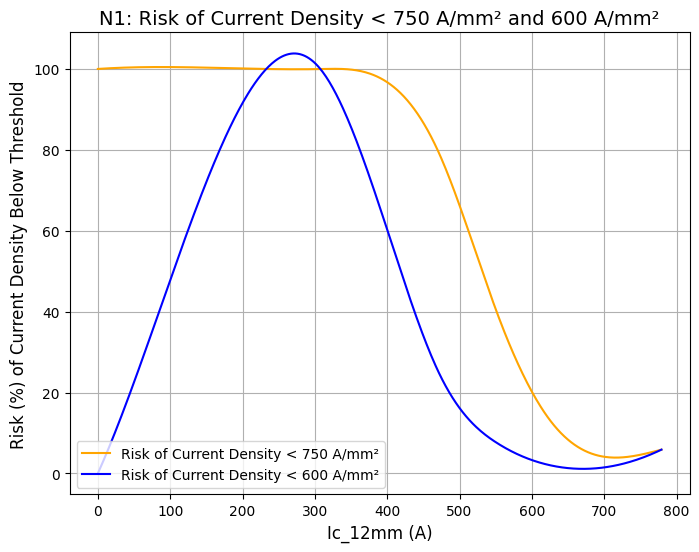

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline

num_bins = 10  # Define the number of bins
n1_dataset['bins'] = pd.cut(n1_dataset['Ic_12mm'], bins=num_bins)

risk_data_n1 = n1_dataset.groupby('bins').agg(
    Ic_12mm_bin_center=('Ic_12mm', 'mean'),
    below_750_risk=('J_4mm_N1', lambda x: (x < 750).mean() * 100),
    below_650_risk=('J_4mm_N1', lambda x: (x < 600).mean() * 100)  
).dropna()

x_vals_smooth = np.linspace(risk_data_n1['Ic_12mm_bin_center'].min(), risk_data_n1['Ic_12mm_bin_center'].max(), 500)
risk_spline_750 = UnivariateSpline(risk_data_n1['Ic_12mm_bin_center'], risk_data_n1['below_750_risk'], s=0.5)
risk_spline_650 = UnivariateSpline(risk_data_n1['Ic_12mm_bin_center'], risk_data_n1['below_650_risk'], s=0.5)

# Smoothed risk curves
smoothed_risk_750 = risk_spline_750(x_vals_smooth)
smoothed_risk_650 = risk_spline_650(x_vals_smooth) #the names are 650 because previously I had looked for 650 as I thought that was the limit.

plt.figure(figsize=(8, 6))

plt.plot(x_vals_smooth, smoothed_risk_750, color='orange', label='Risk of Current Density < 750 A/mm²')

plt.plot(x_vals_smooth, smoothed_risk_650, color='blue', label='Risk of Current Density < 600 A/mm²')
#smoothed spline curve goes above 100% for a portion, this can be ignored as it is basically 100%.

plt.xlabel('Ic_12mm (A)', fontsize=12)
plt.ylabel('Risk (%) of Current Density Below Threshold', fontsize=12)
plt.title('N1: Risk of Current Density < 750 A/mm² and 600 A/mm²', fontsize=14)

plt.grid(True)
plt.legend()

plt.show()


/var/folders/xz/5v9t2v4n0_x9g5q2tltg8ggm0000gp/T/ipykernel_19714/4077888534.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  envelope_data_n2_clean = n2_dataset.groupby('bins').agg(


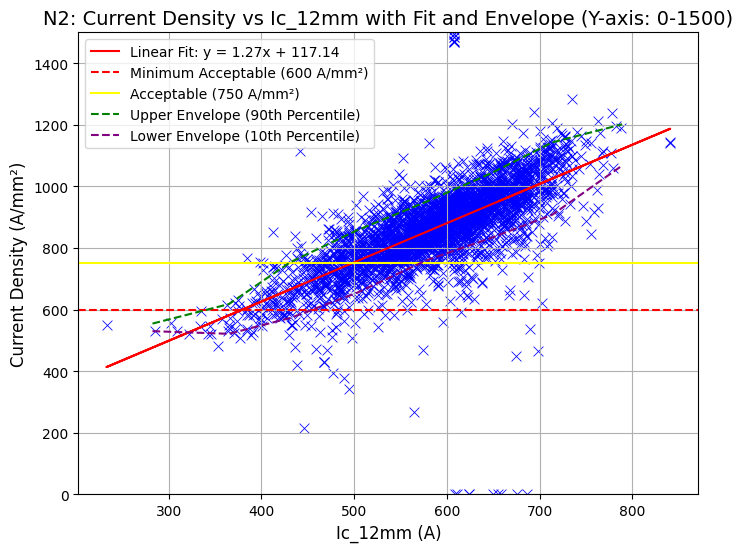

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

X_n2_clean = n2_dataset['Ic_12mm'].values.reshape(-1, 1)  
y_n2_clean = n2_dataset['J_4mm_N2'].values  

model_n2_clean = LinearRegression()
model_n2_clean.fit(X_n2_clean, y_n2_clean)

slope_n2_clean = model_n2_clean.coef_[0]
intercept_n2_clean = model_n2_clean.intercept_

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Ic_12mm', y='J_4mm_N2', data=n2_dataset, s=50, color='blue', marker='x')

plt.plot(n2_dataset['Ic_12mm'], model_n2_clean.predict(X_n2_clean), color='red', label=f'Linear Fit: y = {slope_n2_clean:.2f}x + {intercept_n2_clean:.2f}')

plt.axhline(y=600, color='red', linestyle='--', label='Minimum Acceptable (600 A/mm²)')
plt.axhline(y=750, color='yellow', linestyle='-', label='Acceptable (750 A/mm²)')

num_bins = 8  
n2_dataset['bins'] = pd.cut(n2_dataset['Ic_12mm'], bins=num_bins)

# Filter out empty bins and calculate the percentiles
def safe_percentile(x, q):
    if len(x) > 1:
        return np.percentile(x, q)
    else:
        return np.nan 

envelope_data_n2_clean = n2_dataset.groupby('bins').agg(
    Ic_12mm_bin_center=('Ic_12mm', 'mean'),
    J_4mm_N2_max=('J_4mm_N2', lambda x: safe_percentile(x, 90)),
    J_4mm_N2_min=('J_4mm_N2', lambda x: safe_percentile(x, 10))
).dropna()

plt.plot(envelope_data_n2_clean['Ic_12mm_bin_center'], envelope_data_n2_clean['J_4mm_N2_max'], color='green', linestyle='--', label='Upper Envelope (90th Percentile)')
plt.plot(envelope_data_n2_clean['Ic_12mm_bin_center'], envelope_data_n2_clean['J_4mm_N2_min'], color='purple', linestyle='--', label='Lower Envelope (10th Percentile)')

plt.ylim(0, 1500)

plt.xlabel('Ic_12mm (A)', fontsize=12)
plt.ylabel('Current Density (A/mm²)', fontsize=12)
plt.title('N2: Current Density vs Ic_12mm with Fit and Envelope (Y-axis: 0-1500)', fontsize=14)

plt.legend()
plt.grid(True)

plt.show()


/var/folders/xz/5v9t2v4n0_x9g5q2tltg8ggm0000gp/T/ipykernel_19714/1999545772.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_data_n1 = n1_dataset.groupby('bins').agg(
/var/folders/xz/5v9t2v4n0_x9g5q2tltg8ggm0000gp/T/ipykernel_19714/1999545772.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_data_n2 = n2_dataset.groupby('bins').agg(
/var/folders/xz/5v9t2v4n0_x9g5q2tltg8ggm0000gp/T/ipykernel_19714/1999545772.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True

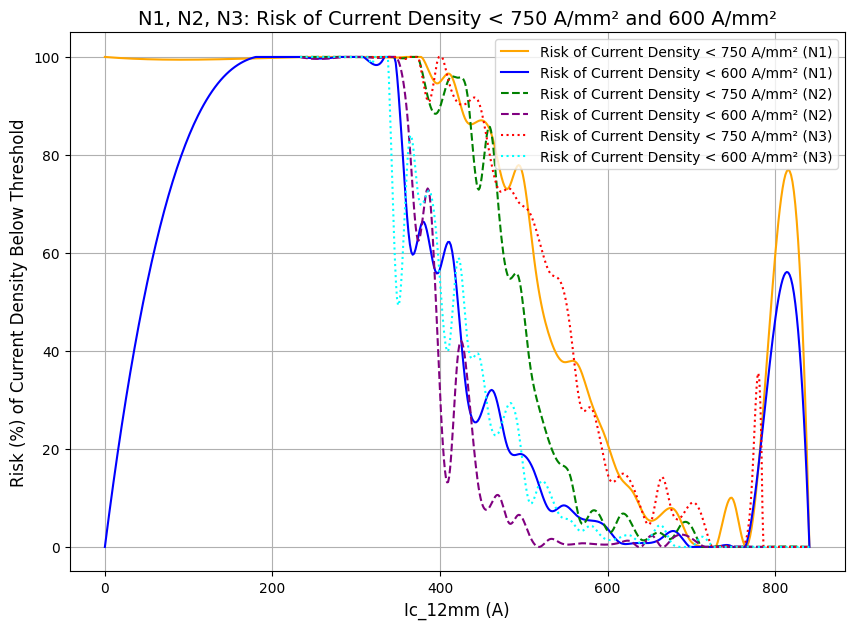

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline


# Define the number of bins
num_bins = 50 #Initial bin number was 10, too few bins might oversimplify the data while too many bins might make the data more noisy
#You can adjust this however it makes more sense

n1_dataset['bins'] = pd.cut(n1_dataset['Ic_12mm'], bins=num_bins)
n2_dataset['bins'] = pd.cut(n2_dataset['Ic_12mm'], bins=num_bins)
n3_dataset['bins'] = pd.cut(n3_dataset['Ic_12mm'], bins=num_bins)

# Risk calculations for N1, N2, and N3
risk_data_n1 = n1_dataset.groupby('bins').agg(
    Ic_12mm_bin_center=('Ic_12mm', 'mean'),
    below_750_risk=('J_4mm_N1', lambda x: (x < 750).mean() * 100),
    below_600_risk=('J_4mm_N1', lambda x: (x < 600).mean() * 100)
).dropna()

risk_data_n2 = n2_dataset.groupby('bins').agg(
    Ic_12mm_bin_center=('Ic_12mm', 'mean'),
    below_750_risk=('J_4mm_N2', lambda x: (x < 750).mean() * 100),
    below_600_risk=('J_4mm_N2', lambda x: (x < 600).mean() * 100)
).dropna()

risk_data_n3 = n3_dataset.groupby('bins').agg(
    Ic_12mm_bin_center=('Ic_12mm', 'mean'),
    below_750_risk=('J_4mm_N3', lambda x: (x < 750).mean() * 100),
    below_600_risk=('J_4mm_N3', lambda x: (x < 600).mean() * 100)
).dropna()

# Generate smooth curves for N1
x_vals_smooth_n1 = np.linspace(risk_data_n1['Ic_12mm_bin_center'].min(), risk_data_n1['Ic_12mm_bin_center'].max(), 500)
risk_spline_750_n1 = UnivariateSpline(risk_data_n1['Ic_12mm_bin_center'], risk_data_n1['below_750_risk'], s=0.5)
risk_spline_600_n1 = UnivariateSpline(risk_data_n1['Ic_12mm_bin_center'], risk_data_n1['below_600_risk'], s=0.5)
smoothed_risk_750_n1 = np.clip(risk_spline_750_n1(x_vals_smooth_n1), 0, 100)
smoothed_risk_600_n1 = np.clip(risk_spline_600_n1(x_vals_smooth_n1), 0, 100)

# Generate smooth curves for N2
x_vals_smooth_n2 = np.linspace(risk_data_n2['Ic_12mm_bin_center'].min(), risk_data_n2['Ic_12mm_bin_center'].max(), 500)
risk_spline_750_n2 = UnivariateSpline(risk_data_n2['Ic_12mm_bin_center'], risk_data_n2['below_750_risk'], s=0.5)
risk_spline_600_n2 = UnivariateSpline(risk_data_n2['Ic_12mm_bin_center'], risk_data_n2['below_600_risk'], s=0.5)
smoothed_risk_750_n2 = np.clip(risk_spline_750_n2(x_vals_smooth_n2), 0, 100)
smoothed_risk_600_n2 = np.clip(risk_spline_600_n2(x_vals_smooth_n2), 0, 100)

# Generate smooth curves for N3
x_vals_smooth_n3 = np.linspace(risk_data_n3['Ic_12mm_bin_center'].min(), risk_data_n3['Ic_12mm_bin_center'].max(), 500)
risk_spline_750_n3 = UnivariateSpline(risk_data_n3['Ic_12mm_bin_center'], risk_data_n3['below_750_risk'], s=0.5)
risk_spline_600_n3 = UnivariateSpline(risk_data_n3['Ic_12mm_bin_center'], risk_data_n3['below_600_risk'], s=0.5)
smoothed_risk_750_n3 = np.clip(risk_spline_750_n3(x_vals_smooth_n3), 0, 100)
smoothed_risk_600_n3 = np.clip(risk_spline_600_n3(x_vals_smooth_n3), 0, 100)

# Plot risk curves for N1, N2, and N3 (for 750 A/mm² and 600 A/mm²)
plt.figure(figsize=(10, 7))

# Plot for N1, you can change the color and line style from these lines
plt.plot(x_vals_smooth_n1, smoothed_risk_750_n1, color='orange', label='Risk of Current Density < 750 A/mm² (N1)', linestyle='-')
plt.plot(x_vals_smooth_n1, smoothed_risk_600_n1, color='blue', label='Risk of Current Density < 600 A/mm² (N1)', linestyle='-')

# Plot for N2 
plt.plot(x_vals_smooth_n2, smoothed_risk_750_n2, color='green', label='Risk of Current Density < 750 A/mm² (N2)', linestyle='--')
plt.plot(x_vals_smooth_n2, smoothed_risk_600_n2, color='purple', label='Risk of Current Density < 600 A/mm² (N2)', linestyle='--')

# Plot for N3 
plt.plot(x_vals_smooth_n3, smoothed_risk_750_n3, color='red', label='Risk of Current Density < 750 A/mm² (N3)', linestyle=':')
plt.plot(x_vals_smooth_n3, smoothed_risk_600_n3, color='cyan', label='Risk of Current Density < 600 A/mm² (N3)', linestyle=':')

plt.xlabel('Ic_12mm (A)', fontsize=12)
plt.ylabel('Risk (%) of Current Density Below Threshold', fontsize=12)
plt.title('N1, N2, N3: Risk of Current Density < 750 A/mm² and 600 A/mm²', fontsize=14)

plt.grid(True)
plt.legend()

plt.show()


In [32]:
def print_chances_above_600(risk_data, label):
    risk_data['above_600_chance'] = 100 - risk_data['below_600_risk']
    
    print(f"\nChances of 4mm Ic being above 600 A/mm² for {label}:")
    for index, row in risk_data.iterrows():
        print(f"At Ic_12mm = {row['Ic_12mm_bin_center']:.1f}, chance of Ic_4mm > 600 A/mm² = {row['above_600_chance']:.1f}%")


print_chances_above_600(risk_data_n1, "N1")

print_chances_above_600(risk_data_n2, "N2")

print_chances_above_600(risk_data_n3, "N3")




Chances of 4mm Ic being above 600 A/mm² for N1:
At Ic_12mm = 0.0, chance of Ic_4mm > 600 A/mm² = 100.0%
At Ic_12mm = 233.0, chance of Ic_4mm > 600 A/mm² = 0.0%
At Ic_12mm = 277.0, chance of Ic_4mm > 600 A/mm² = 0.0%
At Ic_12mm = 309.0, chance of Ic_4mm > 600 A/mm² = 0.0%
At Ic_12mm = 334.0, chance of Ic_4mm > 600 A/mm² = 0.0%
At Ic_12mm = 346.5, chance of Ic_4mm > 600 A/mm² = 0.0%
At Ic_12mm = 365.6, chance of Ic_4mm > 600 A/mm² = 40.0%
At Ic_12mm = 379.1, chance of Ic_4mm > 600 A/mm² = 33.3%
At Ic_12mm = 396.4, chance of Ic_4mm > 600 A/mm² = 44.4%
At Ic_12mm = 412.4, chance of Ic_4mm > 600 A/mm² = 37.9%
At Ic_12mm = 430.4, chance of Ic_4mm > 600 A/mm² = 66.7%
At Ic_12mm = 446.3, chance of Ic_4mm > 600 A/mm² = 73.9%
At Ic_12mm = 463.2, chance of Ic_4mm > 600 A/mm² = 68.1%
At Ic_12mm = 480.5, chance of Ic_4mm > 600 A/mm² = 79.6%
At Ic_12mm = 495.5, chance of Ic_4mm > 600 A/mm² = 81.0%
At Ic_12mm = 513.2, chance of Ic_4mm > 600 A/mm² = 85.0%
At Ic_12mm = 530.5, chance of Ic_4mm > 600 A/

In [26]:
#risk_data_n1
#risk_data_n2   #You can uncomment any of these to see the bins and risk at each bin.
#risk_data_n3